In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import patsy

In [4]:
heart = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-2/datasets/heart_disease/heart_disease.csv')

In [5]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [6]:
heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [7]:
heart.sex.unique()

array([1, 0])

In [8]:
heart.age.describe()

count    303.000000
mean      54.438944
std        9.038662
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

In [9]:
X = heart[['age','sex']]
y = heart.chol.values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b825b90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11c198bd0>], dtype=object)

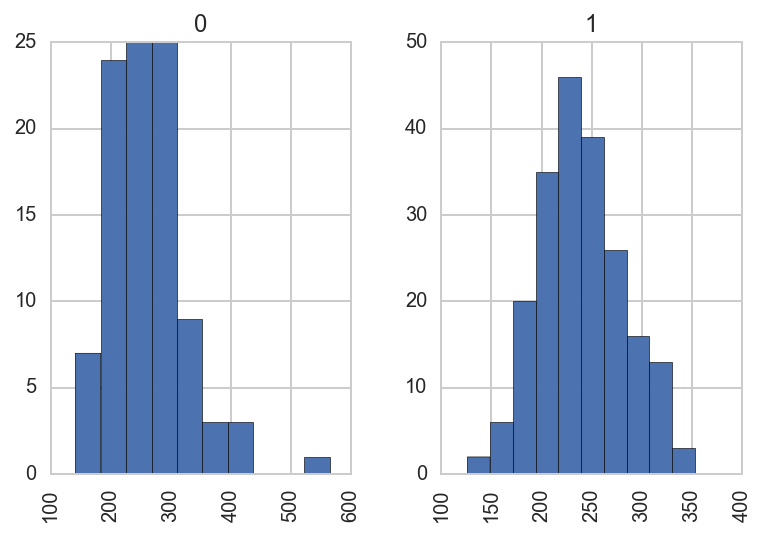

In [11]:
heart.hist(column='chol', by='sex')

In [12]:
linreg = LinearRegression()
linreg.fit(X, y)

//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
print linreg.intercept_
print linreg.coef_

200.700171194
[  1.0956676  -20.08344167]


In [15]:
with pm.Model() as chol_simple:
    family = pm.glm.families.Normal()
    pm.glm.glm('chol ~ sex + age', heart, family=family)

Applied log-transform to sd and added transformed sd_log_ to model.


In [16]:
with chol_simple:
    step = pm.Metropolis()
    chol_trace = pm.sample(100000, step, progressbar=True)

 [-----------------100%-----------------] 100000 of 100000 complete in 31.7 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127bb5090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1285f2910>]], dtype=object)

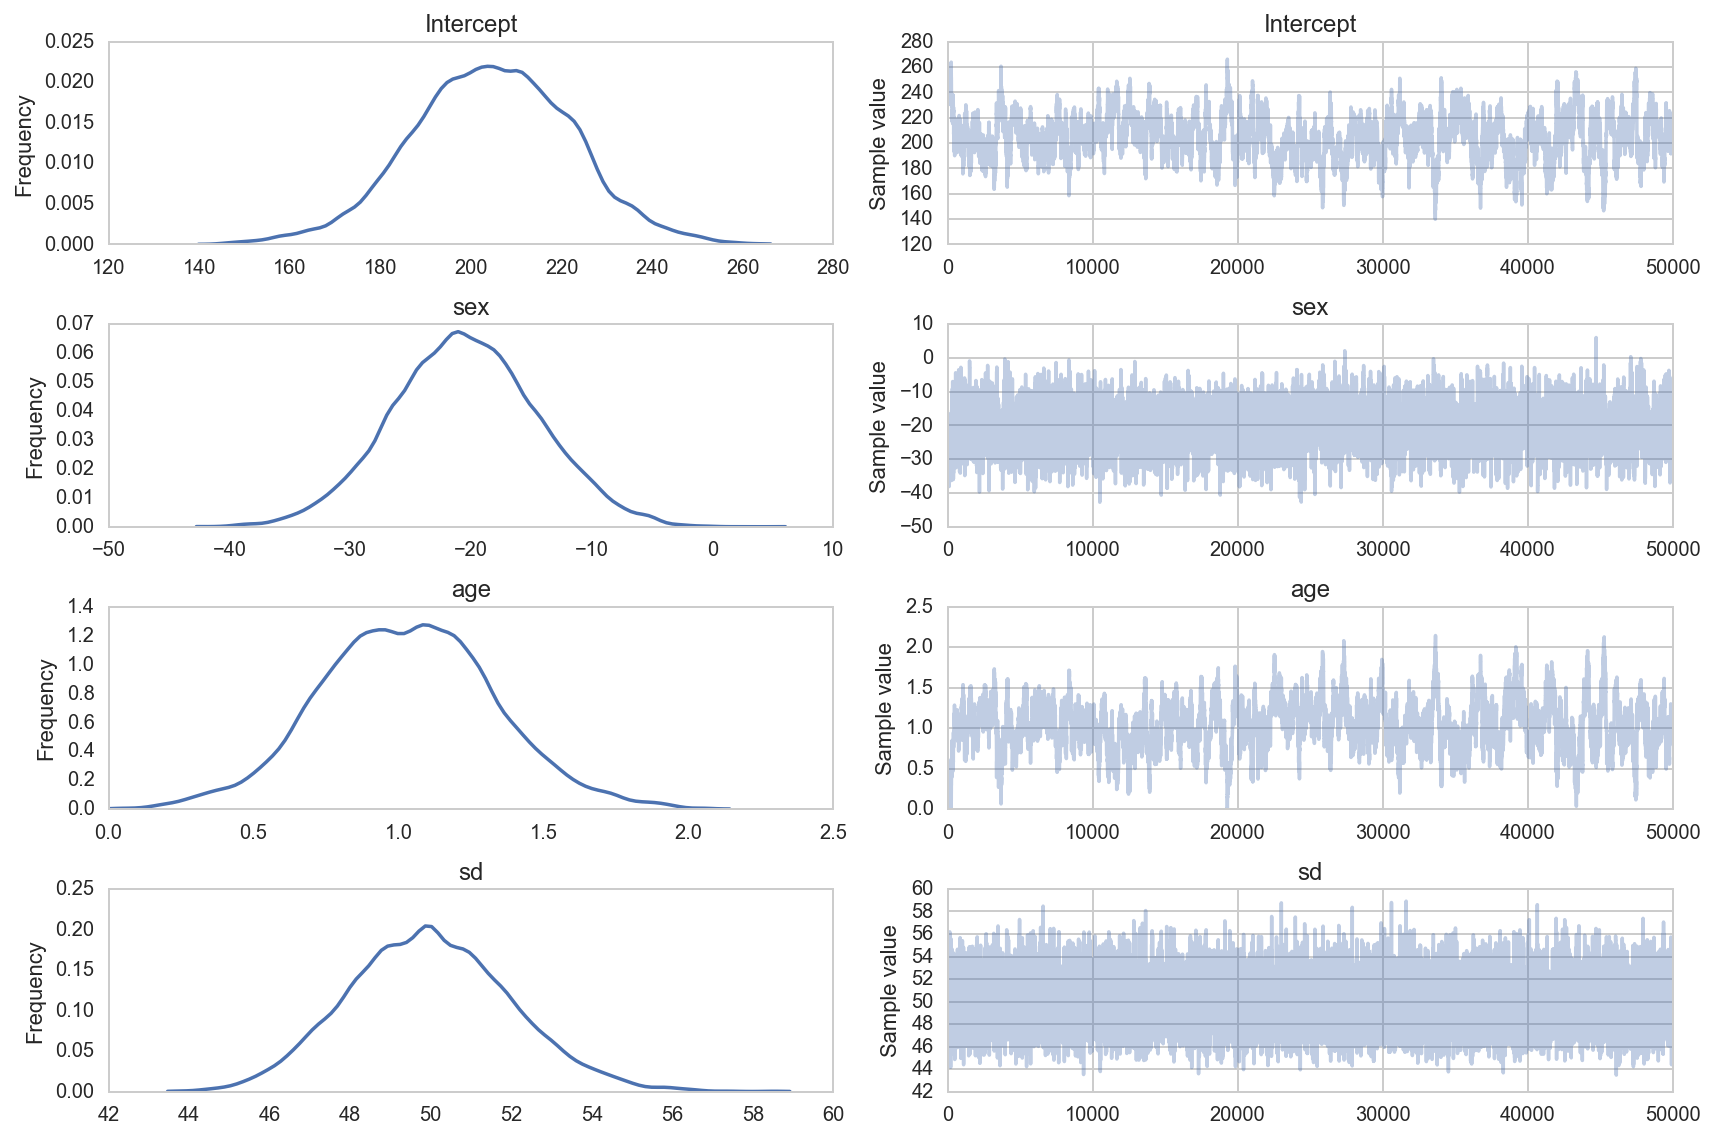

In [17]:
# take 2nd half of the "trace", which is the MCMC samples for the 
# different distributions. Cutting off the initial portion is good
# because it is often landing on bad/unlikely values at the beginning.
# This is called a "burn_in"
pm.traceplot(chol_trace[50000:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x128fc4810>], dtype=object)

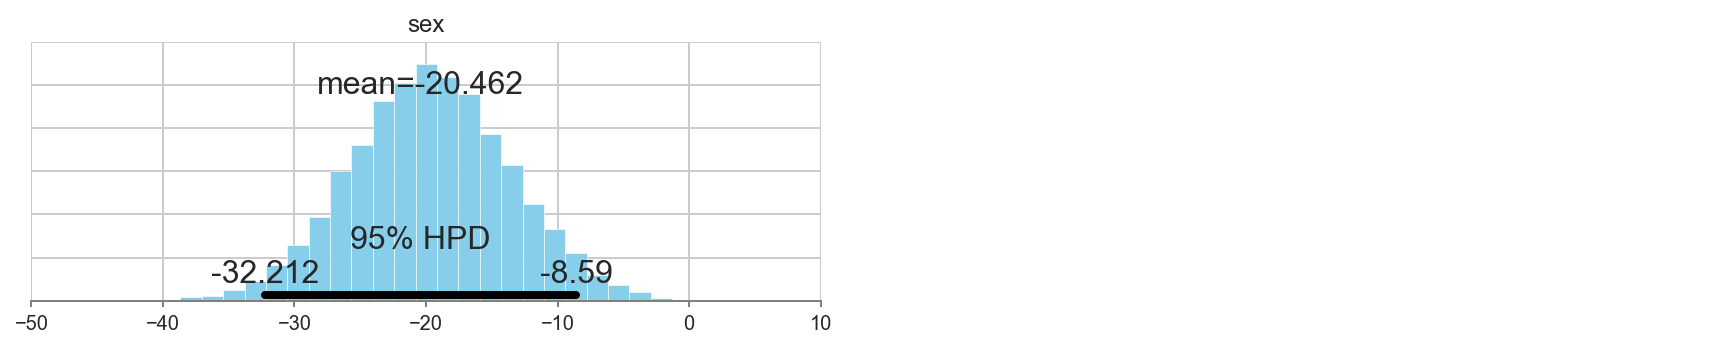

In [18]:
pm.plot_posterior(chol_trace[50000:], varnames=['sex'], color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x129114b90>], dtype=object)

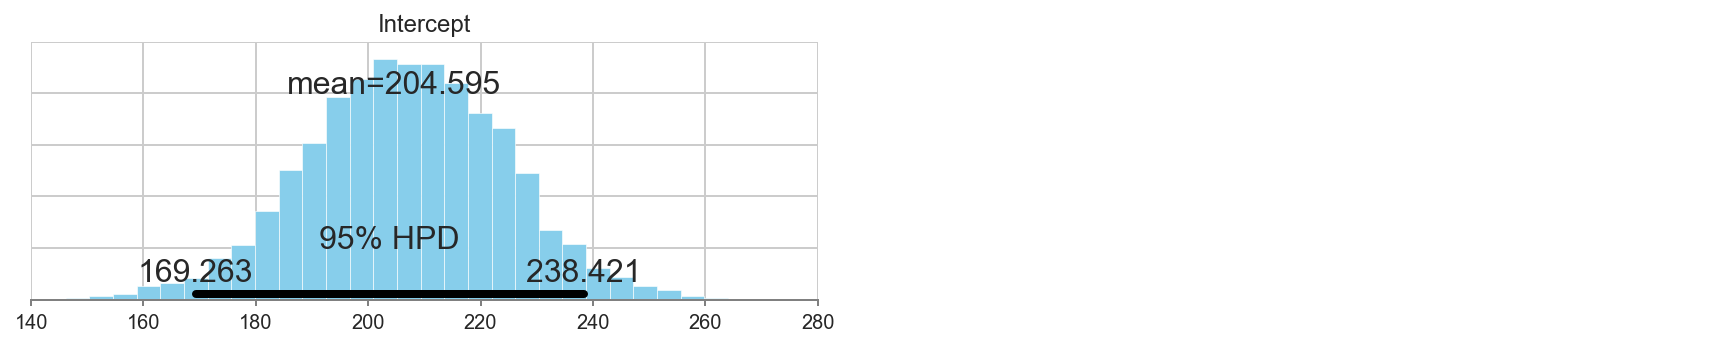

In [19]:
pm.plot_posterior(chol_trace[50000:], varnames=['Intercept'], color='#87ceeb')

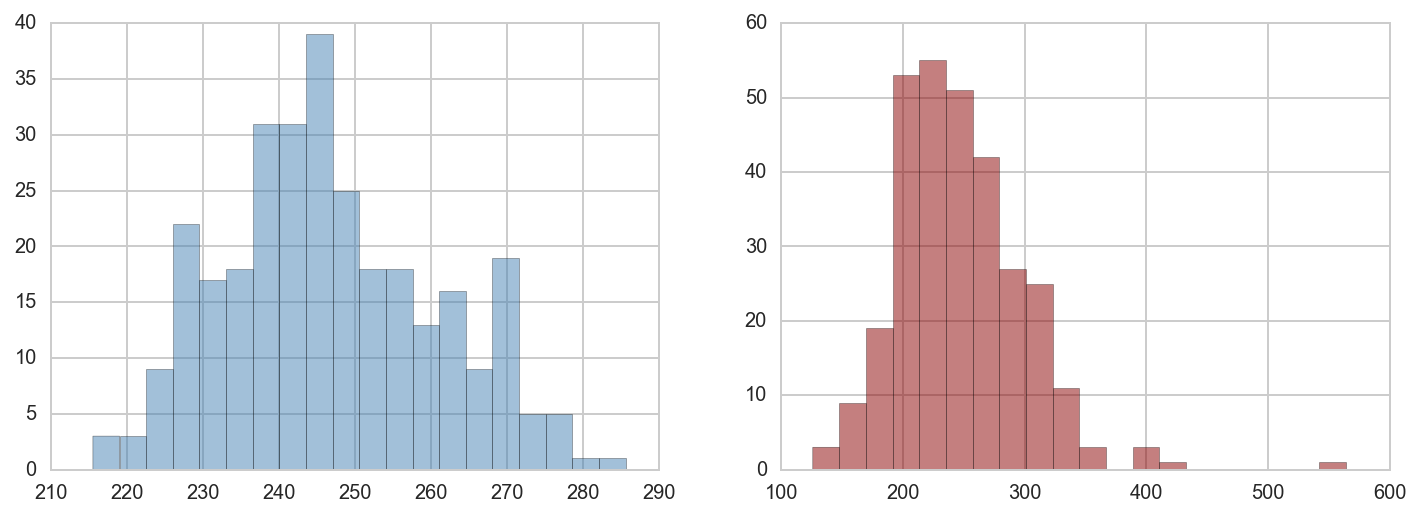

In [38]:
ppc = pm.sample_ppc(chol_trace[50000:], samples=1000, model=chol_simple)

ppc['y'].shape
yhat = np.mean(ppc['y'], axis=0)[0]

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(yhat, bins=20, color='steelblue', alpha=0.5)
ax[1].hist(heart.chol.values, bins=20, color='darkred', alpha=0.5)
plt.show()

In [27]:
heart.shape

(303, 14)

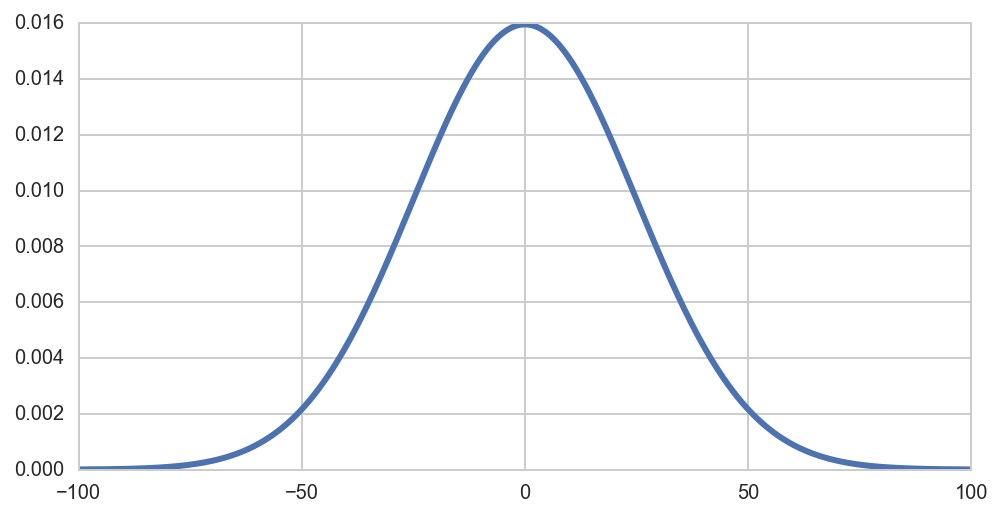

In [54]:
import scipy.stats as stats
int_pdf = stats.norm(loc=0, scale=25)
x_vals = np.linspace(-100, 100, 1000)
pdf_vals = int_pdf.pdf(x_vals)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_vals, pdf_vals, lw=3)
plt.show()

In [69]:
with pm.Model() as chol_manual:
    intercept = pm.Normal('intercept', mu=0, sd=10000)
    
    age_coef = pm.Normal('age_coef', mu=0, sd=10000)
    
    sex_coef = pm.Normal('sex_coef', mu=0, sd=10000.)
    
    chol_est = intercept + sex_coef*heart.sex.values + age_coef*heart.age.values
    
    model_error = pm.Uniform('model_error', lower=0, upper=heart.chol.std()*1000)
    chol_likelihood = pm.Normal('chol_like', mu=chol_est, sd=model_error,
                                observed=heart.chol.values)
    

Applied interval-transform to model_error and added transformed model_error_interval_ to model.


In [70]:
with chol_manual:
    step = pm.Metropolis()
    trace = pm.sample(50000, step)

 [-----------------100%-----------------] 50000 of 50000 complete in 15.1 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13101c590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13233a290>]], dtype=object)

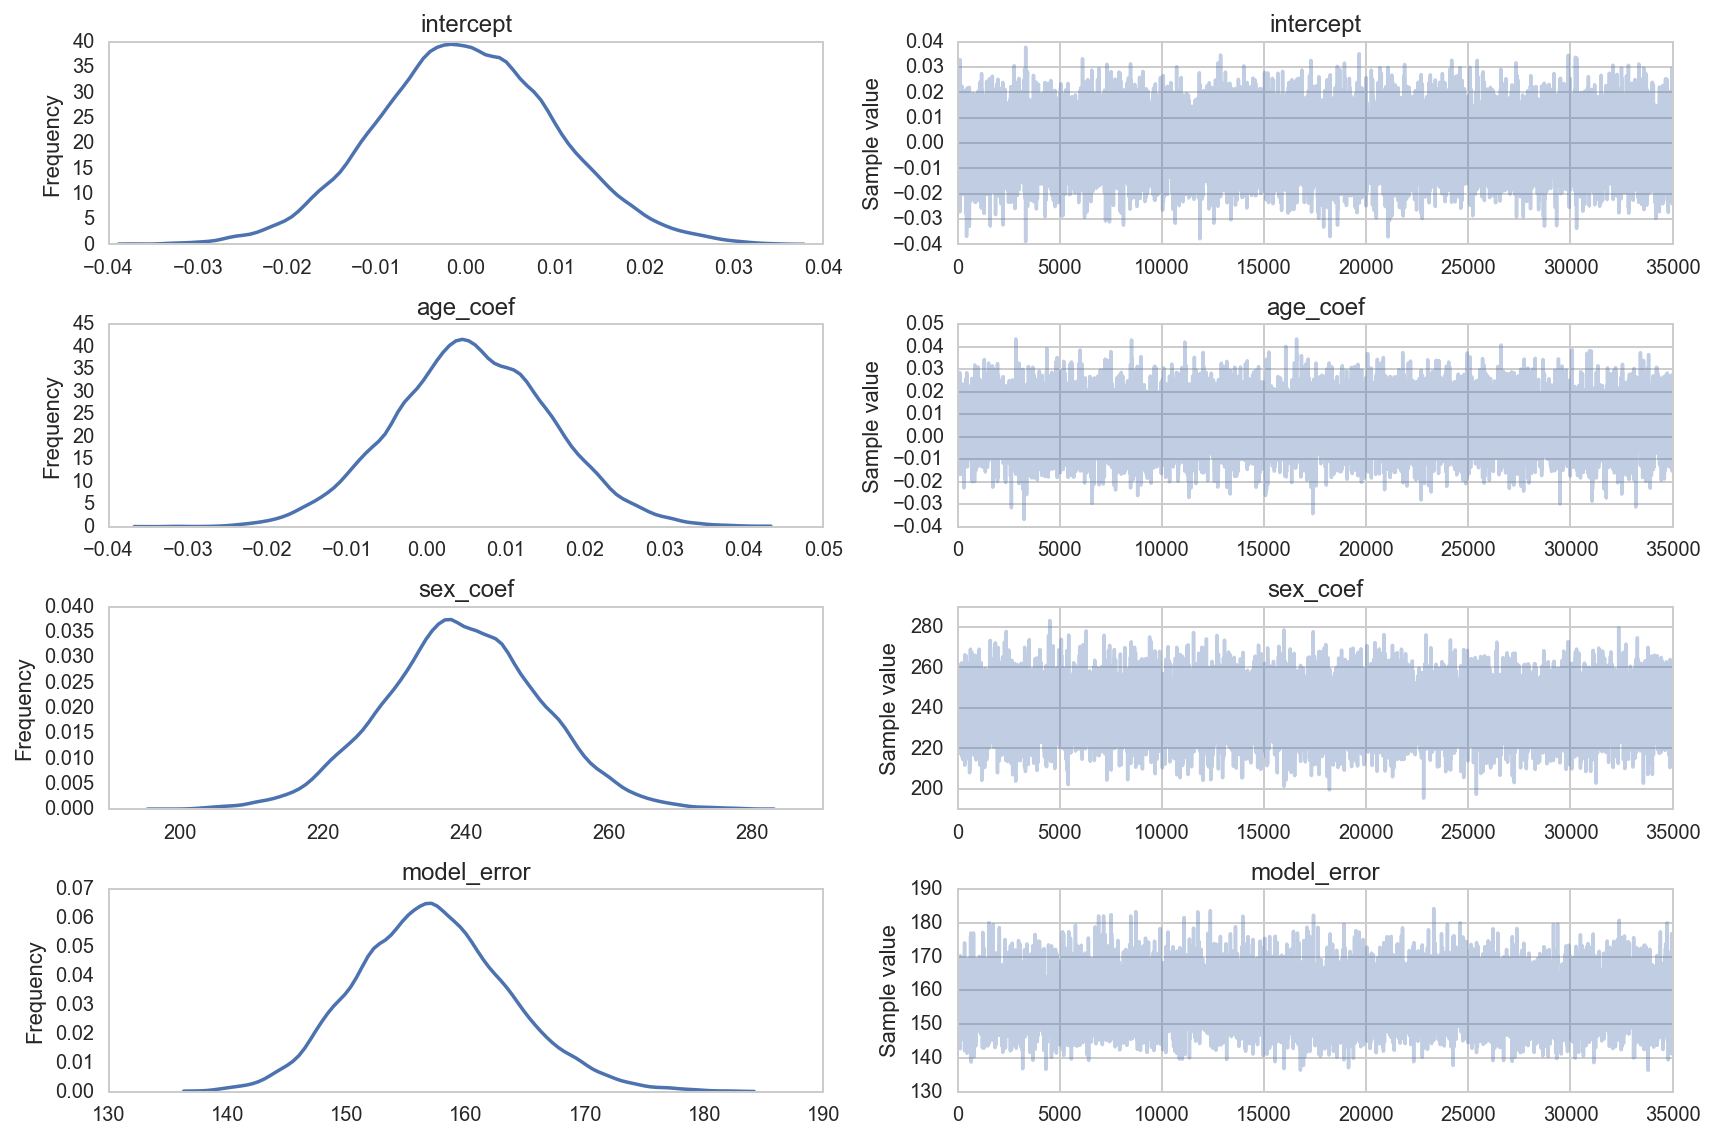

In [71]:
pm.traceplot(trace[15000:])

In [76]:
with chol_manual:
    print pm.find_MAP()

{'model_error_interval_': array(-8.761651084527795), 'intercept': array(0.00010340230349727661), 'sex_coef': array(239.28552420814142), 'age_coef': array(0.005870340117110867)}


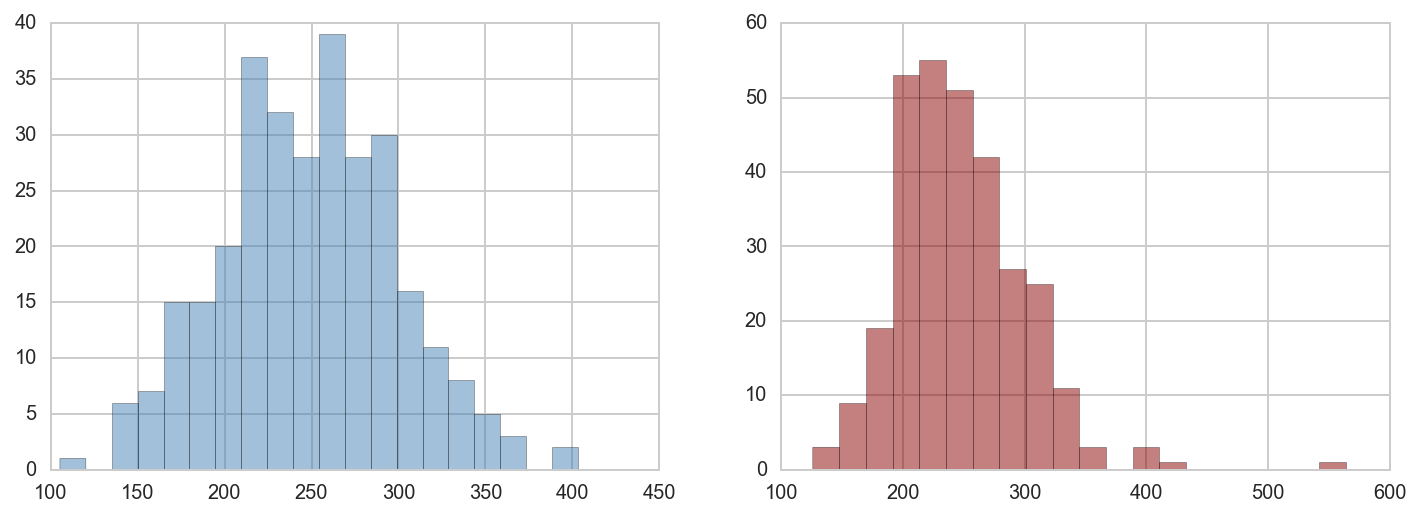

In [65]:
ppc = pm.sample_ppc(trace[15000:], samples=1, model=chol_manual)

ppc['chol_like'].shape
yhat = np.mean(ppc['chol_like'], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(yhat, bins=20, color='steelblue', alpha=0.5)
ax[1].hist(heart.chol.values, bins=20, color='darkred', alpha=0.5)
plt.show()

In [77]:
heart.columns

Index([u'age', u'sex', u'cp', u'trestbps', u'chol', u'fbs', u'restecg',
       u'thalach', u'exang', u'oldpeak', u'slope', u'ca', u'thal', u'num'],
      dtype='object')

In [78]:
heart.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2


In [ ]:
# model age by gender
# sklearn: chol ~ intercept + age + gender + age:gender
#

In [82]:
heart_females = heart[heart.sex == 1].index
heart_males = heart[heart.sex == 0].index
heart_mostly_female = heart.loc[heart_females | heart_males[0:10]]
print heart.shape, heart_mostly_female.shape

(303, 14) (216, 14)


In [83]:
with pm.Model() as age_by_gender:
    
    intercept = pm.Normal('intercept', mu=0, sd=1000.)
    female = pm.Normal('female', mu=0, sd=1000.)
    
    overall_age_mean = pm.Normal('overall_age_mean', mu=0, sd=1000.)
    overall_age_sd = pm.Uniform('overall_age_sd', lower=0, upper=10000.)
    
    age_by_gender_coefs = pm.Normal('age_by_gender',
                                    mu=overall_age_mean,
                                    sd=overall_age_sd,
                                    shape=len(heart_mostly_female.sex.unique()))
    
    # heart.sex.values = [1,1,0,1]
    # age_by_gender_coefs = [Normal_males, Normal_females]
    # age_by_gender_coefs[heart.sex.values] -->
    # --> [Normal_females, Normal_females, Normal_males, Normal_females]
    chol_est = (intercept +
                female*heart_mostly_female.sex.values +
                age_by_gender_coefs[heart_mostly_female.sex.values] * heart_mostly_female.age.values)
    
    model_error = pm.Uniform('model_error', lower=0, upper=10000)
    chol_like = pm.Normal('chol_like', mu=chol_est, sd=model_error,
                          observed=heart_mostly_female.chol.values)
    
    

Applied interval-transform to overall_age_sd and added transformed overall_age_sd_interval_ to model.
Applied interval-transform to model_error and added transformed model_error_interval_ to model.


In [84]:
with age_by_gender:
    step = pm.Metropolis()
    trace = pm.sample(150000, step)

 [-----------------100%-----------------] 150000 of 150000 complete in 80.9 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135562590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14636ccd0>]], dtype=object)

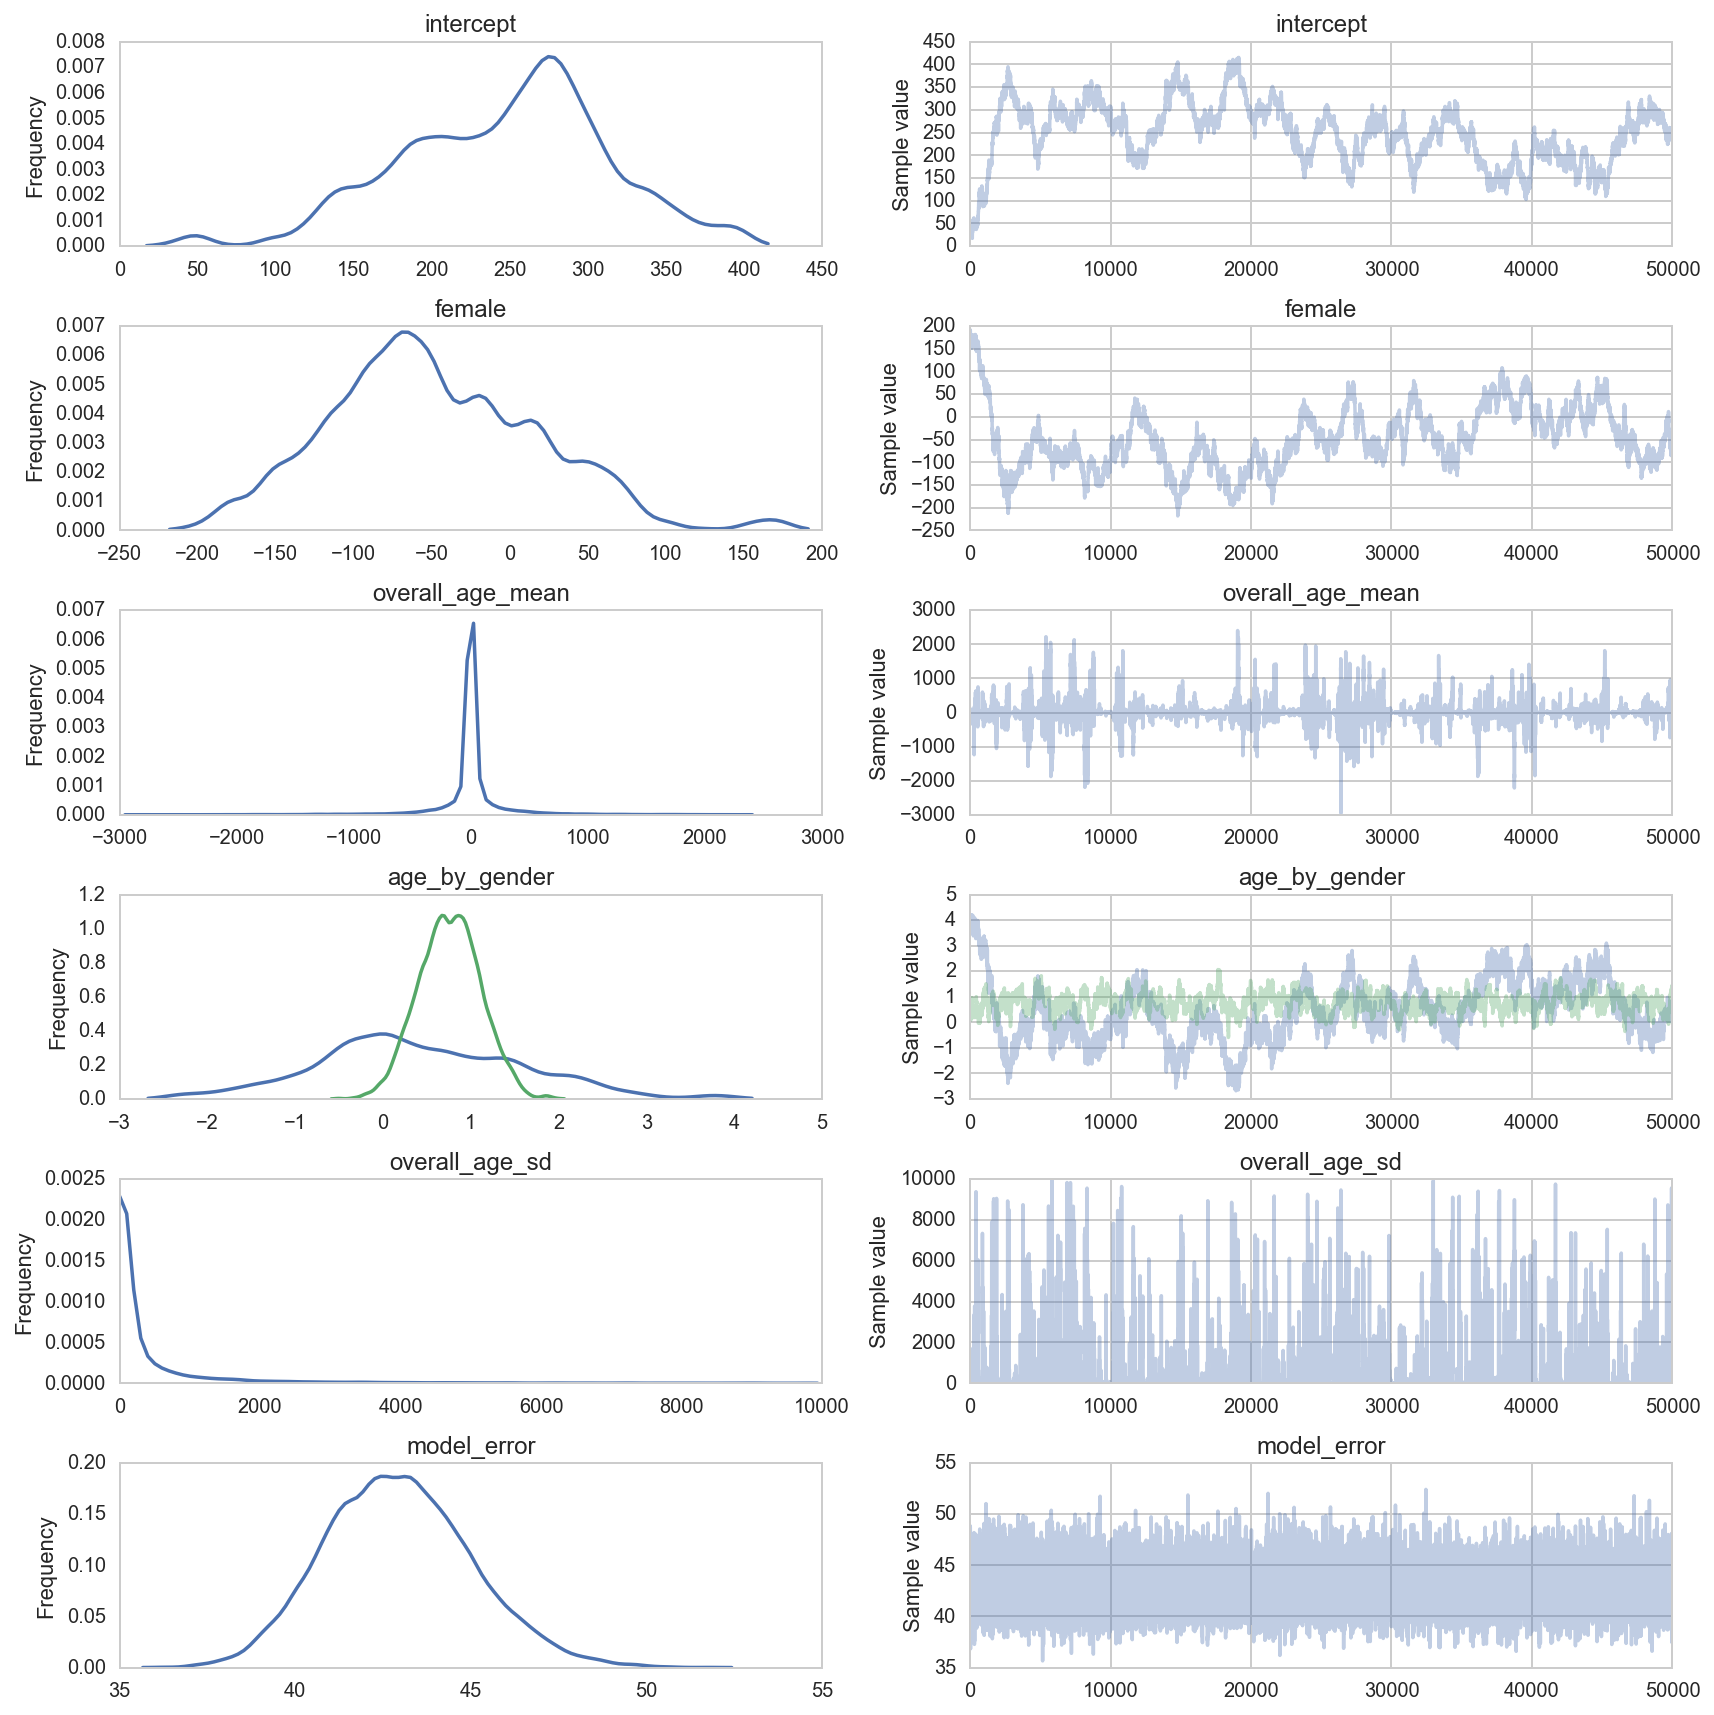

In [86]:
pm.traceplot(trace[100000:])